In [22]:
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as stats

In [23]:
dt = 0.01
time_horizon = 1000
num_steps = int(time_horizon/dt)
num_trajectories = 1000
noise = random.normal(loc=0.0, scale=dt**(1/2), size=(num_trajectories, num_steps))

In [24]:
x_init = 1
jump_mult = 1.5
t = np.linspace(0, time_horizon, num_steps)
epsilon = (4.29 * 2 / np.log(time_horizon)) * jump_mult

In [25]:
def const_neg_potential(x, t, period=100):
    """Defines the potential function."""
    t = 25
    a1, a2, a3, a4, a5, a6 = 0, -3.2, 3*np.sin(2*np.pi*t/period), 0.1, -(3/5)*3*np.sin(2*np.pi*t/period), 1
    all_scale = 1.13
    
    return all_scale * (a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)

def mu(x, t):
    return -const_neg_potential(x, t)

def sigma(x, t):
    return epsilon ** (1/2)

In [26]:
def simulate(x_init, dt, num_trajectories, num_steps, time_vec, noise, delta=5):
    jump_times = np.empty((num_trajectories,))
    x = np.zeros((num_steps,))
    x[0] = x_init
    
    for j in tqdm(range(num_trajectories)):
        sign_change_detected = False
        steps_since_change = 0
        initial_sign = np.sign(x[0])
        potential_jump_time = None
        
        for i in range(num_steps - 1):
            curr_t = time_vec[i]
            curr_x = x[i]
            dW = noise[j, i]
            
            x[i+1] = (curr_x + 
                      mu(curr_x, curr_t) * dt + 
                      sigma(curr_x, curr_t) * dW)
            
            # If we haven't detected a sign change yet
            if not sign_change_detected:
                if np.sign(x[i+1]) != initial_sign:
                    sign_change_detected = True
                    steps_since_change = 0
                    potential_jump_time = curr_t
            
            # If we're monitoring a potential zone transition
            elif steps_since_change < delta:
                steps_since_change += 1
                # If sign reverts back to initial sign, cancel the monitoring
                if np.sign(x[i+1]) == initial_sign:
                    sign_change_detected = False
                    steps_since_change = 0
                    potential_jump_time = None
                
                # If we've monitored for delta steps and sign change persists
                if steps_since_change == delta:
                    jump_times[j] = potential_jump_time
                    break
        
        # If we reach the end without confirming a transition
        if not sign_change_detected or steps_since_change < delta:
            jump_times[j] = np.nan
    
    return x, jump_times

In [27]:
def simulate(x_init, dt, num_trajectories, num_steps, time_vec, noise, delta=6):
    jump_times = np.empty((num_trajectories,))
    # Store multiple trajectories
    trajectories = np.zeros((num_trajectories, num_steps))
    
    for j in tqdm(range(num_trajectories)):
        x = np.zeros((num_steps,))
        x[0] = x_init
        sign_change_detected = False
        steps_since_change = 0
        initial_sign = np.sign(x[0])
        potential_jump_time = None
        
        for i in range(num_steps - 1):
            curr_t = time_vec[i]
            curr_x = x[i]
            dW = noise[j, i]
            
            x[i+1] = (curr_x + 
                      mu(curr_x, curr_t) * dt + 
                      sigma(curr_x, curr_t) * dW)
            
            # If we haven't detected a sign change yet
            if not sign_change_detected:
                if np.sign(x[i+1]) != initial_sign:
                    sign_change_detected = True
                    steps_since_change = 0
                    potential_jump_time = curr_t
            
            # If we're monitoring a potential zone transition
            elif steps_since_change < delta:
                steps_since_change += 1
                # If sign reverts back to initial sign, cancel the monitoring
                if np.sign(x[i+1]) == initial_sign:
                    sign_change_detected = False
                    steps_since_change = 0
                    potential_jump_time = None
                
                # If we've monitored for delta steps and sign change persists
                if steps_since_change == delta:
                    jump_times[j] = potential_jump_time
                    break
        
        # Store the complete trajectory for this iteration
        trajectories[j] = x
        
        # If we reach the end without confirming a transition
        if not sign_change_detected or steps_since_change < delta:
            jump_times[j] = np.nan
    
    # Return the first 6 trajectories along with jump times
    return trajectories[:6], jump_times

In [28]:
traj, jump_times = simulate(x_init, dt, num_trajectories, num_steps, t, noise)
data = jump_times.copy()

100%|██████████| 1000/1000 [00:00<00:00, 1149.08it/s]


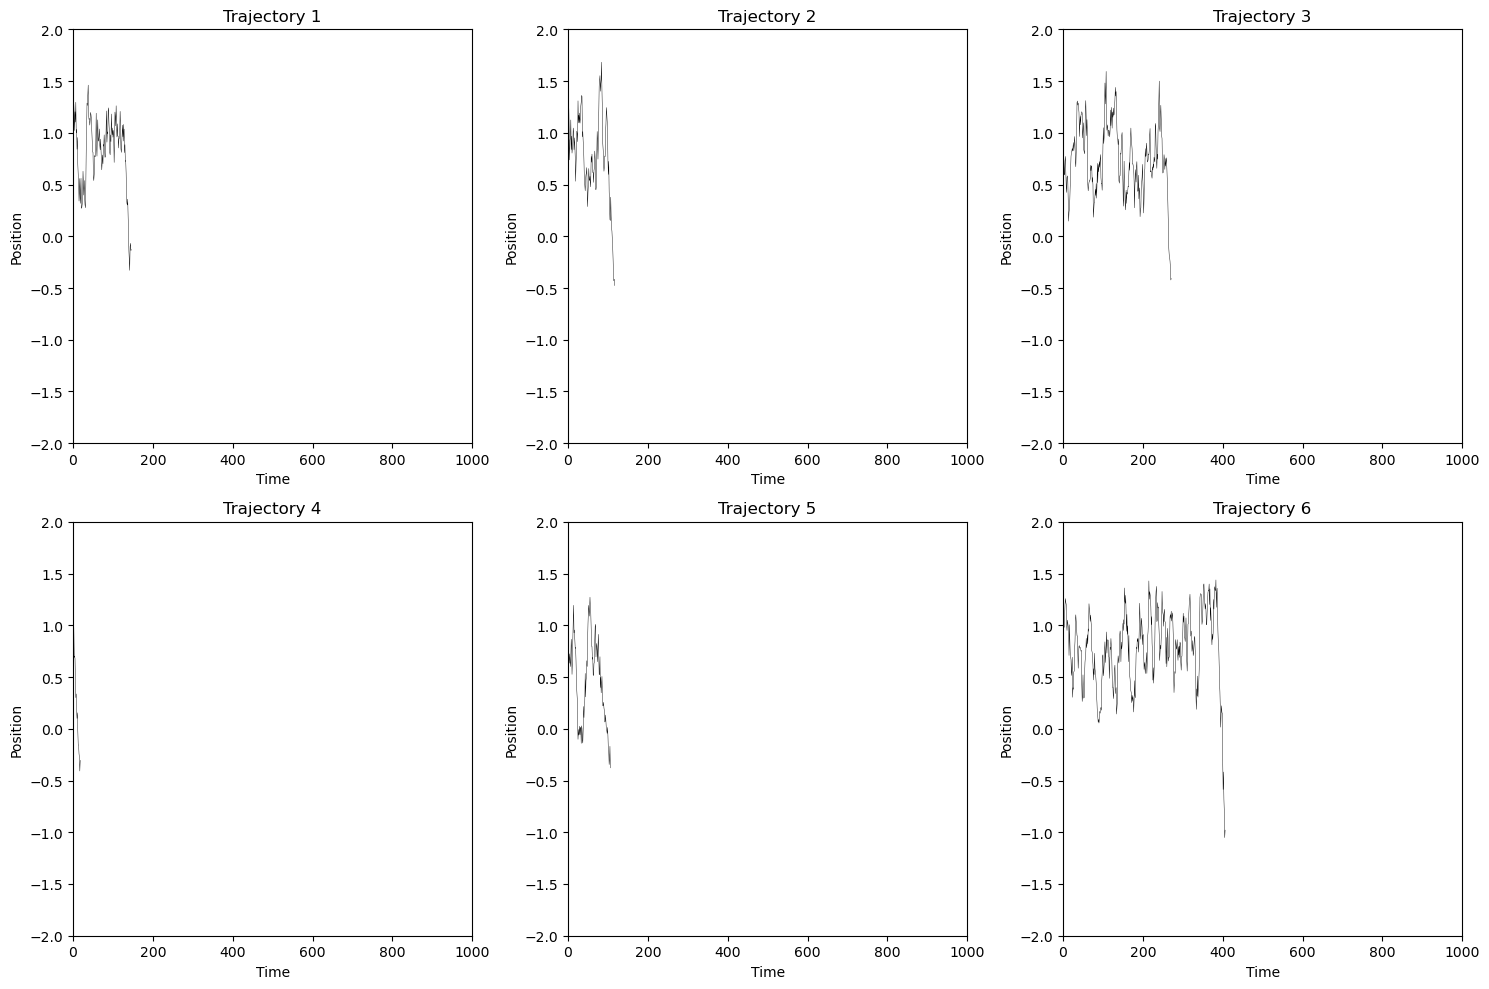

In [29]:

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the 2D array of axes for easier iteration
axs = axs.flatten()

# Plot each trajectory in its own subplot
for i in range(6):
    new_traj = traj[i][traj[i] != 0]
    axs[i].plot(new_traj, color='black', linewidth=0.3)
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Position')
    # keep x-axis the same throughout plots
    axs[i].set_xlim(0, 1000)
    axs[i].set_ylim(-2, 2)
    axs[i].set_title(f'Trajectory {i+1}')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.savefig('6_trajectories_per_jump.svg', transparent=True)
plt.show()

---

In [30]:
theoretical_rate = 1/(np.exp(1.17 * 2/epsilon))
rate = 1/np.mean(data)
print(f"Theoretical rate: {theoretical_rate}, Measured rate: {rate}")

Theoretical rate: 0.2848035868435802, Measured rate: 0.41487335864086133


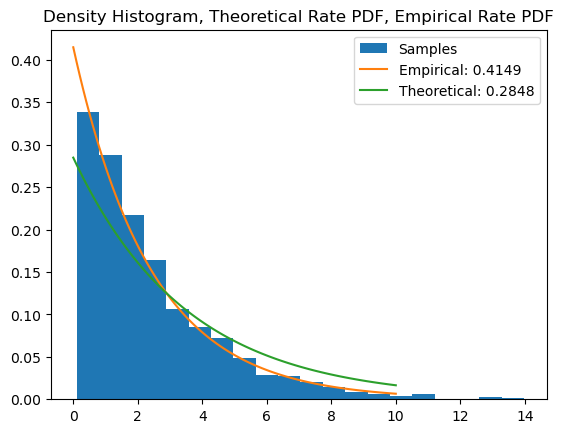

In [31]:
x = np.linspace(0, 10, 100)
y = rate * np.exp(-rate * x)

plt.hist(data, density=True, bins=20, label='Samples')
plt.plot(x, y, label=f'Empirical: {np.round(rate, 4)}')
plt.plot(x, theoretical_rate * np.exp(-theoretical_rate * x), label=f'Theoretical: {np.round(theoretical_rate, 4)}')
plt.title('Density Histogram, Theoretical Rate PDF, Empirical Rate PDF')
plt.legend()
plt.show()

In [32]:
def exp_cdf(x, rate=theoretical_rate):
    return 1 - np.exp(-rate * x)

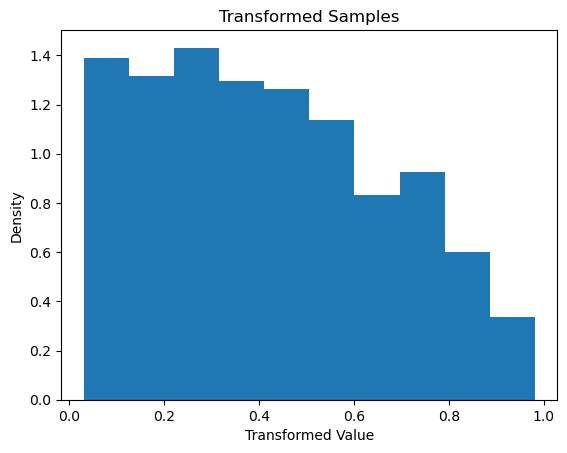

In [33]:
x_uniformed = exp_cdf(data)
plt.hist(x_uniformed, density=True, label='Transformed Samples')
plt.title('Transformed Samples')
plt.ylabel('Density')
plt.xlabel('Transformed Value')
plt.show()

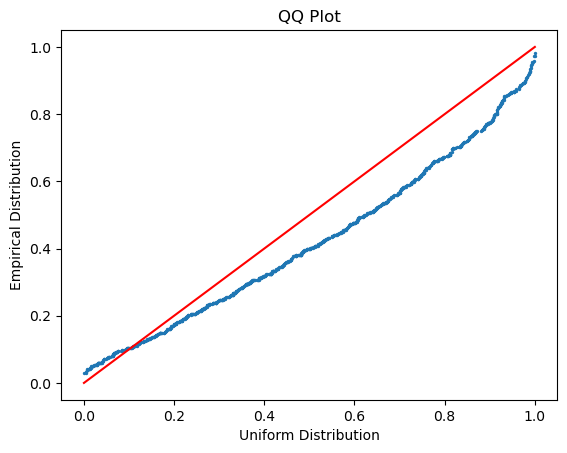

In [34]:
uniform = np.random.uniform(0,1, len(data))
uniform_sort = np.sort(uniform)

plt.scatter(uniform_sort, np.sort(x_uniformed), s=2)
plt.title('QQ Plot')
plt.xlabel('Uniform Distribution')
plt.ylabel('Empirical Distribution')
plt.plot([0,1],[0,1], color='red')
plt.savefig(f'{num_trajectories}_trajectories_qq_plot.svg', transparent=True)
plt.show()

In [35]:
stats.anderson(data, dist='expon')

AndersonResult(statistic=8.029260773928172, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0, scale=2.410374103741037)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [36]:
stats.cramervonmises(x_uniformed, 'uniform')

CramerVonMisesResult(statistic=8.863481821960274, pvalue=2.005224875034628e-10)

In [37]:
stats.chisquare(x_uniformed)

Power_divergenceResult(statistic=143.08281686128942, pvalue=1.0)

In [38]:
obs_counts, bin_edges = np.histogram(x_uniformed, bins=20)

total_count = obs_counts.sum()
num_categories = obs_counts.size

expected = np.full(num_categories, total_count / num_categories)

stats.chisquare(f_obs=obs_counts, f_exp=expected)

Power_divergenceResult(statistic=113.51999999999998, pvalue=1.7829405034441537e-15)